In [1]:
import pandas as pd
import numpy as np
from glob import glob
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from utils.stats import calculate_dice_mean, median_confidence_interval, calculate_subgroup_metric_median_stats, friedman_with_posthoc

In [2]:
def aggregate_csvs(csvs):
    dfs = []
    for c in csvs:
        df_ = pd.read_csv(c)
        df_['fold'] = c.split('_')[-1].split('.')[0]
        dfs.append(df_)
    df_all = pd.concat(dfs, axis=0)
    return df_all

In [3]:
seg_csvs = glob('./results/*_ptx_seg_*.csv')
len(seg_csvs)

105

In [4]:
df = aggregate_csvs(seg_csvs)
df['ImagePath'] = df.paths.apply(lambda x: x.split('/')[-1])
df

iou      dice                                              paths  \
0    0.472557  0.641818  /mnt/NAS3/datasets/external/SIIM_ACR_Pneumotho...   
1    0.058714  0.110915  /mnt/NAS3/datasets/external/SIIM_ACR_Pneumotho...   
2    0.254786  0.406103  /mnt/NAS3/datasets/external/SIIM_ACR_Pneumotho...   
3    0.214689  0.353488  /mnt/NAS3/datasets/external/SIIM_ACR_Pneumotho...   
4    0.229028  0.372698  /mnt/NAS3/datasets/external/SIIM_ACR_Pneumotho...   
..        ...       ...                                                ...   
470  0.454806  0.625246  /mnt/NAS3/datasets/external/SIIM_ACR_Pneumotho...   
471  0.622922  0.767655  /mnt/NAS3/datasets/external/SIIM_ACR_Pneumotho...   
472  0.567037  0.723706  /mnt/NAS3/datasets/external/SIIM_ACR_Pneumotho...   
473  0.000259  0.000517  /mnt/NAS3/datasets/external/SIIM_ACR_Pneumotho...   
474  0.525695  0.689122  /mnt/NAS3/datasets/external/SIIM_ACR_Pneumotho...   

     freeze       model          task        target fold  \
0         1  BiomedCLIP  segmentation  pneumothorax    0   
1         1  BiomedCLIP  segmentation  pneumothorax    0   
2         1  BiomedCLIP  segmentation  pneumothorax    0   
3         1  BiomedCLIP  segmentation  pneumothorax    0   
4         1  BiomedCLIP  segmentation  pneumothorax    0   
..      ...         ...           ...           ...  ...   
470       0   SegFormer  segmentation  pneumothorax    4   
471       0   SegFormer  segmentation  pneumothorax    4   
472       0   SegFormer  segmentation  pneumothorax    4   
473       0   SegFormer  segmentation  pneumothorax    4   
474       0   SegFormer  segmentation  pneumothorax    4   

                                             ImagePath  
0    1.2.276.0.7230010.3.1.4.8323329.2421.151787517...  
1    1.2.276.0.7230010.3.1.4.8323329.31802.15178751...  
2    1.2.276.0.7230010.3.1.4.8323329.14213.15178752...  
3    1.2.276.0.7230010.3.1.4.8323329.5614.151787518...  
4    1.2.276.0.7230010.3.1.4.8323329.13422.15178752...  
..                                                 ...  
470  1.2.276.0.7230010.3.1.4.8323329.10318.15178752...  
471  1.2.276.0.7230010.3.1.4.8323329.32609.15178751...  
472  1.2.276.0.7230010.3.1.4.8323329.512.1517875163...  
473  1.2.276.0.7230010.3.1.4.8323329.12402.15178752...  
474  1.2.276.0.7230010.3.1.4.8323329.1690.151787516...  

[49959 rows x 9 columns]

In [5]:
ptx_vol = pd.read_csv('./inputs/ptx_volume_pct.csv')
ptx_vol

ImagePath    Volume  \
0     1.2.276.0.7230010.3.1.4.8323329.4904.151787518...  0.898170   
1     1.2.276.0.7230010.3.1.4.8323329.32579.15178751...  1.129913   
2     1.2.276.0.7230010.3.1.4.8323329.1314.151787516...  2.773190   
3     1.2.276.0.7230010.3.1.4.8323329.4440.151787518...  0.237083   
4     1.2.276.0.7230010.3.1.4.8323329.4982.151787518...  0.498962   
...                                                 ...       ...   
2374  1.2.276.0.7230010.3.1.4.8323329.3335.151787517...  0.377274   
2375  1.2.276.0.7230010.3.1.4.8323329.1805.151787516...  0.655651   
2376  1.2.276.0.7230010.3.1.4.8323329.32260.15178751...  0.727844   
2377  1.2.276.0.7230010.3.1.4.8323329.32459.15178751...  0.522995   
2378  1.2.276.0.7230010.3.1.4.8323329.4461.151787518...  1.905918   

     Volume Quartile  
0                 Q3  
1                 Q3  
2                 Q4  
3                 Q1  
4                 Q2  
...              ...  
2374              Q2  
2375              Q2  
2376              Q2  
2377              Q2  
2378              Q4  

[2379 rows x 3 columns]

In [6]:
tube = pd.read_csv('/mnt/NAS3/datasets/external/SIIM_ACR_Pneumothorax/MDai_Label_SIIM.csv')
tube['ImagePath'] = tube.ImagePath.apply(lambda x: x.split('/')[-1][:-4]+'.png')
tube = tube[['ImagePath','ChestTube']]
tube

ImagePath  ChestTube
0      1.2.276.0.7230010.3.1.4.8323329.1000.151787516...          0
1      1.2.276.0.7230010.3.1.4.8323329.10000.15178752...          0
2      1.2.276.0.7230010.3.1.4.8323329.10001.15178752...          0
3      1.2.276.0.7230010.3.1.4.8323329.10002.15178752...          0
4      1.2.276.0.7230010.3.1.4.8323329.10003.15178752...          0
...                                                  ...        ...
10670  1.2.276.0.7230010.3.1.4.8323329.5792.151787519...          0
10671  1.2.276.0.7230010.3.1.4.8323329.5793.151787519...          0
10672  1.2.276.0.7230010.3.1.4.8323329.5794.151787519...          0
10673  1.2.276.0.7230010.3.1.4.8323329.5795.151787519...          1
10674  1.2.276.0.7230010.3.1.4.8323329.5796.151787519...          0

[10675 rows x 2 columns]

In [7]:
df = df.merge(ptx_vol, on='ImagePath', how='left')
df = df.merge(tube, on='ImagePath', how='left')
df

iou      dice                                              paths  \
0      0.472557  0.641818  /mnt/NAS3/datasets/external/SIIM_ACR_Pneumotho...   
1      0.058714  0.110915  /mnt/NAS3/datasets/external/SIIM_ACR_Pneumotho...   
2      0.254786  0.406103  /mnt/NAS3/datasets/external/SIIM_ACR_Pneumotho...   
3      0.214689  0.353488  /mnt/NAS3/datasets/external/SIIM_ACR_Pneumotho...   
4      0.229028  0.372698  /mnt/NAS3/datasets/external/SIIM_ACR_Pneumotho...   
...         ...       ...                                                ...   
49954  0.454806  0.625246  /mnt/NAS3/datasets/external/SIIM_ACR_Pneumotho...   
49955  0.622922  0.767655  /mnt/NAS3/datasets/external/SIIM_ACR_Pneumotho...   
49956  0.567037  0.723706  /mnt/NAS3/datasets/external/SIIM_ACR_Pneumotho...   
49957  0.000259  0.000517  /mnt/NAS3/datasets/external/SIIM_ACR_Pneumotho...   
49958  0.525695  0.689122  /mnt/NAS3/datasets/external/SIIM_ACR_Pneumotho...   

       freeze       model          task        target fold  \
0           1  BiomedCLIP  segmentation  pneumothorax    0   
1           1  BiomedCLIP  segmentation  pneumothorax    0   
2           1  BiomedCLIP  segmentation  pneumothorax    0   
3           1  BiomedCLIP  segmentation  pneumothorax    0   
4           1  BiomedCLIP  segmentation  pneumothorax    0   
...       ...         ...           ...           ...  ...   
49954       0   SegFormer  segmentation  pneumothorax    4   
49955       0   SegFormer  segmentation  pneumothorax    4   
49956       0   SegFormer  segmentation  pneumothorax    4   
49957       0   SegFormer  segmentation  pneumothorax    4   
49958       0   SegFormer  segmentation  pneumothorax    4   

                                               ImagePath    Volume  \
0      1.2.276.0.7230010.3.1.4.8323329.2421.151787517...  0.753021   
1      1.2.276.0.7230010.3.1.4.8323329.31802.15178751...  5.468082   
2      1.2.276.0.7230010.3.1.4.8323329.14213.15178752...  1.470089   
3      1.2.276.0.7230010.3.1.4.8323329.5614.151787518...  1.035976   
4      1.2.276.0.7230010.3.1.4.8323329.13422.15178752...  0.680161   
...                                                  ...       ...   
49954  1.2.276.0.7230010.3.1.4.8323329.10318.15178752...  2.824593   
49955  1.2.276.0.7230010.3.1.4.8323329.32609.15178751...  1.000118   
49956  1.2.276.0.7230010.3.1.4.8323329.512.1517875163...  0.938797   
49957  1.2.276.0.7230010.3.1.4.8323329.12402.15178752...  0.380707   
49958  1.2.276.0.7230010.3.1.4.8323329.1690.151787516...  0.746727   

      Volume Quartile  ChestTube  
0                  Q2          0  
1                  Q4          1  
2                  Q3          0  
3                  Q3          1  
4                  Q2          0  
...               ...        ...  
49954              Q4          1  
49955              Q3          1  
49956              Q3          1  
49957              Q2          1  
49958              Q2          1  

[49959 rows x 12 columns]

In [8]:
df['Vol-Tube'] = df.apply(lambda x: f'{x['Volume Quartile']}-{x['ChestTube']}', axis=1) 
df

iou      dice                                              paths  \
0      0.472557  0.641818  /mnt/NAS3/datasets/external/SIIM_ACR_Pneumotho...   
1      0.058714  0.110915  /mnt/NAS3/datasets/external/SIIM_ACR_Pneumotho...   
2      0.254786  0.406103  /mnt/NAS3/datasets/external/SIIM_ACR_Pneumotho...   
3      0.214689  0.353488  /mnt/NAS3/datasets/external/SIIM_ACR_Pneumotho...   
4      0.229028  0.372698  /mnt/NAS3/datasets/external/SIIM_ACR_Pneumotho...   
...         ...       ...                                                ...   
49954  0.454806  0.625246  /mnt/NAS3/datasets/external/SIIM_ACR_Pneumotho...   
49955  0.622922  0.767655  /mnt/NAS3/datasets/external/SIIM_ACR_Pneumotho...   
49956  0.567037  0.723706  /mnt/NAS3/datasets/external/SIIM_ACR_Pneumotho...   
49957  0.000259  0.000517  /mnt/NAS3/datasets/external/SIIM_ACR_Pneumotho...   
49958  0.525695  0.689122  /mnt/NAS3/datasets/external/SIIM_ACR_Pneumotho...   

       freeze       model          task        target fold  \
0           1  BiomedCLIP  segmentation  pneumothorax    0   
1           1  BiomedCLIP  segmentation  pneumothorax    0   
2           1  BiomedCLIP  segmentation  pneumothorax    0   
3           1  BiomedCLIP  segmentation  pneumothorax    0   
4           1  BiomedCLIP  segmentation  pneumothorax    0   
...       ...         ...           ...           ...  ...   
49954       0   SegFormer  segmentation  pneumothorax    4   
49955       0   SegFormer  segmentation  pneumothorax    4   
49956       0   SegFormer  segmentation  pneumothorax    4   
49957       0   SegFormer  segmentation  pneumothorax    4   
49958       0   SegFormer  segmentation  pneumothorax    4   

                                               ImagePath    Volume  \
0      1.2.276.0.7230010.3.1.4.8323329.2421.151787517...  0.753021   
1      1.2.276.0.7230010.3.1.4.8323329.31802.15178751...  5.468082   
2      1.2.276.0.7230010.3.1.4.8323329.14213.15178752...  1.470089   
3      1.2.276.0.7230010.3.1.4.8323329.5614.151787518...  1.035976   
4      1.2.276.0.7230010.3.1.4.8323329.13422.15178752...  0.680161   
...                                                  ...       ...   
49954  1.2.276.0.7230010.3.1.4.8323329.10318.15178752...  2.824593   
49955  1.2.276.0.7230010.3.1.4.8323329.32609.15178751...  1.000118   
49956  1.2.276.0.7230010.3.1.4.8323329.512.1517875163...  0.938797   
49957  1.2.276.0.7230010.3.1.4.8323329.12402.15178752...  0.380707   
49958  1.2.276.0.7230010.3.1.4.8323329.1690.151787516...  0.746727   

      Volume Quartile  ChestTube Vol-Tube  
0                  Q2          0     Q2-0  
1                  Q4          1     Q4-1  
2                  Q3          0     Q3-0  
3                  Q3          1     Q3-1  
4                  Q2          0     Q2-0  
...               ...        ...      ...  
49954              Q4          1     Q4-1  
49955              Q3          1     Q3-1  
49956              Q3          1     Q3-1  
49957              Q2          1     Q2-1  
49958              Q2          1     Q2-1  

[49959 rows x 13 columns]

In [9]:
df.to_csv('./stats/4_2_cv_scores_seg_subgroup.csv', index=False)

In [10]:
def plot_metric_by_quartile(df, metric_col, figsize=(18, 9), palette='Set2', 
                           freeze_labels=None, quartile_col='Volume Quartile', y_lim=None, model_list=None,
                           highlight_models=None, highlight_color='red', highlight_label=None):
    """
    Plot any metric with confidence intervals using freeze as hue and quartiles as subplots.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing columns: 'model', 'freeze', quartile_col, 
        metric_col, 'ci_lower', 'ci_upper'
    metric_col : str
        Name of the metric column to plot (e.g., 'Sensitivity', 'Specificity', 'AUC')
    figsize : tuple, default (15, 10)
        Figure size (width, height)
    palette : str, default 'Set2'
        Color palette for different freeze values
    freeze_labels : dict, optional
        Custom labels for freeze values {0: 'label0', 1: 'label1'}
        Default: {1: 'Linear Probing', 0: 'Fine-tuning'}
    quartile_col : str, default 'Volume Quartile'
        Name of the quartile/grouping column
    y_lim : tuple, optional
        Y-axis limits as (min, max). If None, uses automatic limits.
    model_list : list, optional
        Specific list of models to plot. If None, uses all models from data.
    highlight_models : list or str, optional
        Models to highlight with different color. Can be:
        - 'last': highlight only the last model
        - list of model names: highlight specific models
        - None: no highlighting
    highlight_color : str, default 'red'
        Color to use for highlighted model bars
    highlight_label : str, optional
        Custom label for highlighted models in legend. If None, auto-generates label
    
    Returns:
    --------
    fig, axes : matplotlib figure and axes objects
    """
    
    # Default freeze labels
    if freeze_labels is None:
        freeze_labels = {1: 'Linear Probing', 0: 'Fine-tuning'}
    
    # Get unique quartiles and freeze values
    quartiles = sorted(df[quartile_col].unique())
    freeze_values = [1, 0]  # sorted(df['freeze'].unique())
    
    # Create subplots
    n_quartiles = len(quartiles)
    n_cols = min(2, n_quartiles)  # Max 3 columns
    n_rows = (n_quartiles + n_cols - 1) // n_cols  # Ceiling division
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize, squeeze=False, sharey=True, dpi=300)
    
    # Create color palette for freeze values
    colors = sns.color_palette(palette, len(freeze_values))
    color_map = dict(zip(freeze_values, colors))
    
    # Determine which models to highlight
    if model_list is None:
        all_models = sorted(df['model'].unique())
    else:
        all_models = model_list
    
    models_to_highlight = []
    if highlight_models == 'last':
        models_to_highlight = [all_models[-1]]
    elif isinstance(highlight_models, list):
        models_to_highlight = highlight_models
    elif isinstance(highlight_models, str) and highlight_models != 'last':
        models_to_highlight = [highlight_models]
    
    # Plot for each quartile
    for idx, quartile in enumerate(quartiles):
        row = idx // n_cols
        col = idx % n_cols
        ax = axes[row, col]
        
        # Filter data for current quartile
        quartile_data = df[df[quartile_col] == quartile].copy()
        
        # Group by model and freeze values for plotting
        if model_list is None:
            models = sorted(quartile_data['model'].unique())
        else:
            models = model_list

        x_positions = np.arange(len(models))
        
        # Width for grouped bars
        width = 0.8 / len(freeze_values)
        
        for i, freeze_val in enumerate(freeze_values):
            freeze_data = quartile_data[quartile_data['freeze'] == freeze_val]
            
            # Get data for each model
            model_metrics = []
            model_ci_lower = []
            model_ci_upper = []
            model_positions = []
            bar_colors = []
            
            for model in models:
                model_data = freeze_data[freeze_data['model'] == model]
                if not model_data.empty:
                    model_metrics.append(model_data[metric_col].iloc[0])
                    model_ci_lower.append(model_data['ci_lower'].iloc[0])
                    model_ci_upper.append(model_data['ci_upper'].iloc[0])
                    model_positions.append(x_positions[models.index(model)] + i * width - width * (len(freeze_values) - 1) / 2)
                    
                    # Determine color for this bar
                    if model in models_to_highlight:
                        bar_colors.append(highlight_color)
                    else:
                        bar_colors.append(color_map[freeze_val])
                else:
                    # Handle missing data
                    model_metrics.append(0)
                    model_ci_lower.append(0)
                    model_ci_upper.append(0)
                    model_positions.append(x_positions[models.index(model)] + i * width - width * (len(freeze_values) - 1) / 2)
                    bar_colors.append(color_map[freeze_val])
            
            # Calculate error bars (distance from center to bounds)
            yerr_lower = np.array(model_metrics) - np.array(model_ci_lower)
            yerr_upper = np.array(model_ci_upper) - np.array(model_metrics)
            yerr = [yerr_lower, yerr_upper]
            
            # Get freeze label for legend
            freeze_label = freeze_labels.get(freeze_val, f'Freeze {freeze_val}')
            
            # Plot bars with error bars
            bars = ax.bar(model_positions, model_metrics, width, 
                         label=freeze_label, 
                         color=bar_colors, 
                         alpha=0.8, 
                         capsize=3)
            
            # Add error bars
            ax.errorbar(model_positions, model_metrics, 
                       yerr=yerr, fmt='none', 
                       color='black', capsize=3, capthick=1)
        
        # Customize subplot
        if idx % n_cols == 0:  # First column
            ax.set_ylabel(metric_col, fontsize=14)
        
        ax.set_title(f'{quartile_col}: {quartile}', fontsize=14)
        ax.set_xticks(x_positions)
        ax.set_xticklabels(models, rotation=45, ha='right', fontsize=14)
        ax.tick_params(axis='y', labelsize=14)
        ax.grid(True, alpha=0.3, axis='y')
        
        # Create legend with freeze colors and highlighted models
        legend_elements = []
        
        # Add freeze legend entries
        for freeze_val in freeze_values:
            freeze_label = freeze_labels.get(freeze_val, f'Freeze {freeze_val}')
            legend_elements.append(plt.Rectangle((0,0),1,1, 
                                               facecolor=color_map[freeze_val], 
                                               alpha=0.8, 
                                               label=freeze_label))
        
        # Add highlighted models legend entry if applicable
        if models_to_highlight:
            if highlight_label:
                legend_label = highlight_label
            elif len(models_to_highlight) == 1 and highlight_models == 'last':
                legend_label = f"Highlighted ({models_to_highlight[0]})"
            elif len(models_to_highlight) == 1:
                legend_label = f"Highlighted ({models_to_highlight[0]})"
            else:
                legend_label = "Highlighted Models"
            
            legend_elements.append(plt.Rectangle((0,0),1,1, 
                                               facecolor=highlight_color, 
                                               alpha=0.8, 
                                               label=legend_label))
        
        ax.legend(handles=legend_elements, loc='lower right', fontsize=14)
        
        # Set y-axis limits if specified
        if y_lim is not None:
            ax.set_ylim(y_lim)
        
        # Add value labels on bars (optional)
        for i, freeze_val in enumerate(freeze_values):
            freeze_data = quartile_data[quartile_data['freeze'] == freeze_val]
            for j, model in enumerate(models):
                model_data = freeze_data[freeze_data['model'] == model]
                if not model_data.empty:
                    metric_value = model_data[metric_col].iloc[0]
                    upper = model_data['ci_upper'].iloc[0]
                    x_pos = x_positions[j] + i * width - width * (len(freeze_values) - 1) / 2
                    ax.text(x_pos, upper + 0.005, f'{metric_value:.2f}', 
                           ha='center', va='bottom', fontsize=10, rotation=0)
    
    # Hide empty subplots
    total_subplots = n_rows * n_cols
    for idx in range(n_quartiles, total_subplots):
        row = idx // n_cols
        col = idx % n_cols
        axes[row, col].set_visible(False)
    
    # Adjust layout
    plt.tight_layout()
    
    return fig, axes

In [11]:
models = ['Ark+(16)', 'BiomedCLIP', 'CheXagent', 'MedImageInsights(16)', 'MedSigLIP', 'RAD-DINO', 'DINOv2', 'SigLIP2', 'SegFormer']
colors = sns.color_palette('Set2', 3)

In [12]:
# avg_iou_tube = calculate_subgroup_metric_stats(df, 'ChestTube', calculate_iou_mean, calculate_CI_width, metric_name='IoU')

# fig, axes = plot_metric_by_quartile(avg_iou_tube, 'IoU', figsize=(18, 9), palette='Set2', quartile_col='ChestTube', y_lim=(0.0, 0.5), model_list=models, highlight_models='SegFormer', highlight_color=colors[2], highlight_label='End-to-end')
# plt.show()

/mnt/NAS3/homes/fli40/FM_evaluation/utils/stats.py:163: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  subgroup_metric = df_sub.groupby(['fold', 'model', 'freeze', groupby_column]).apply(metric_function)


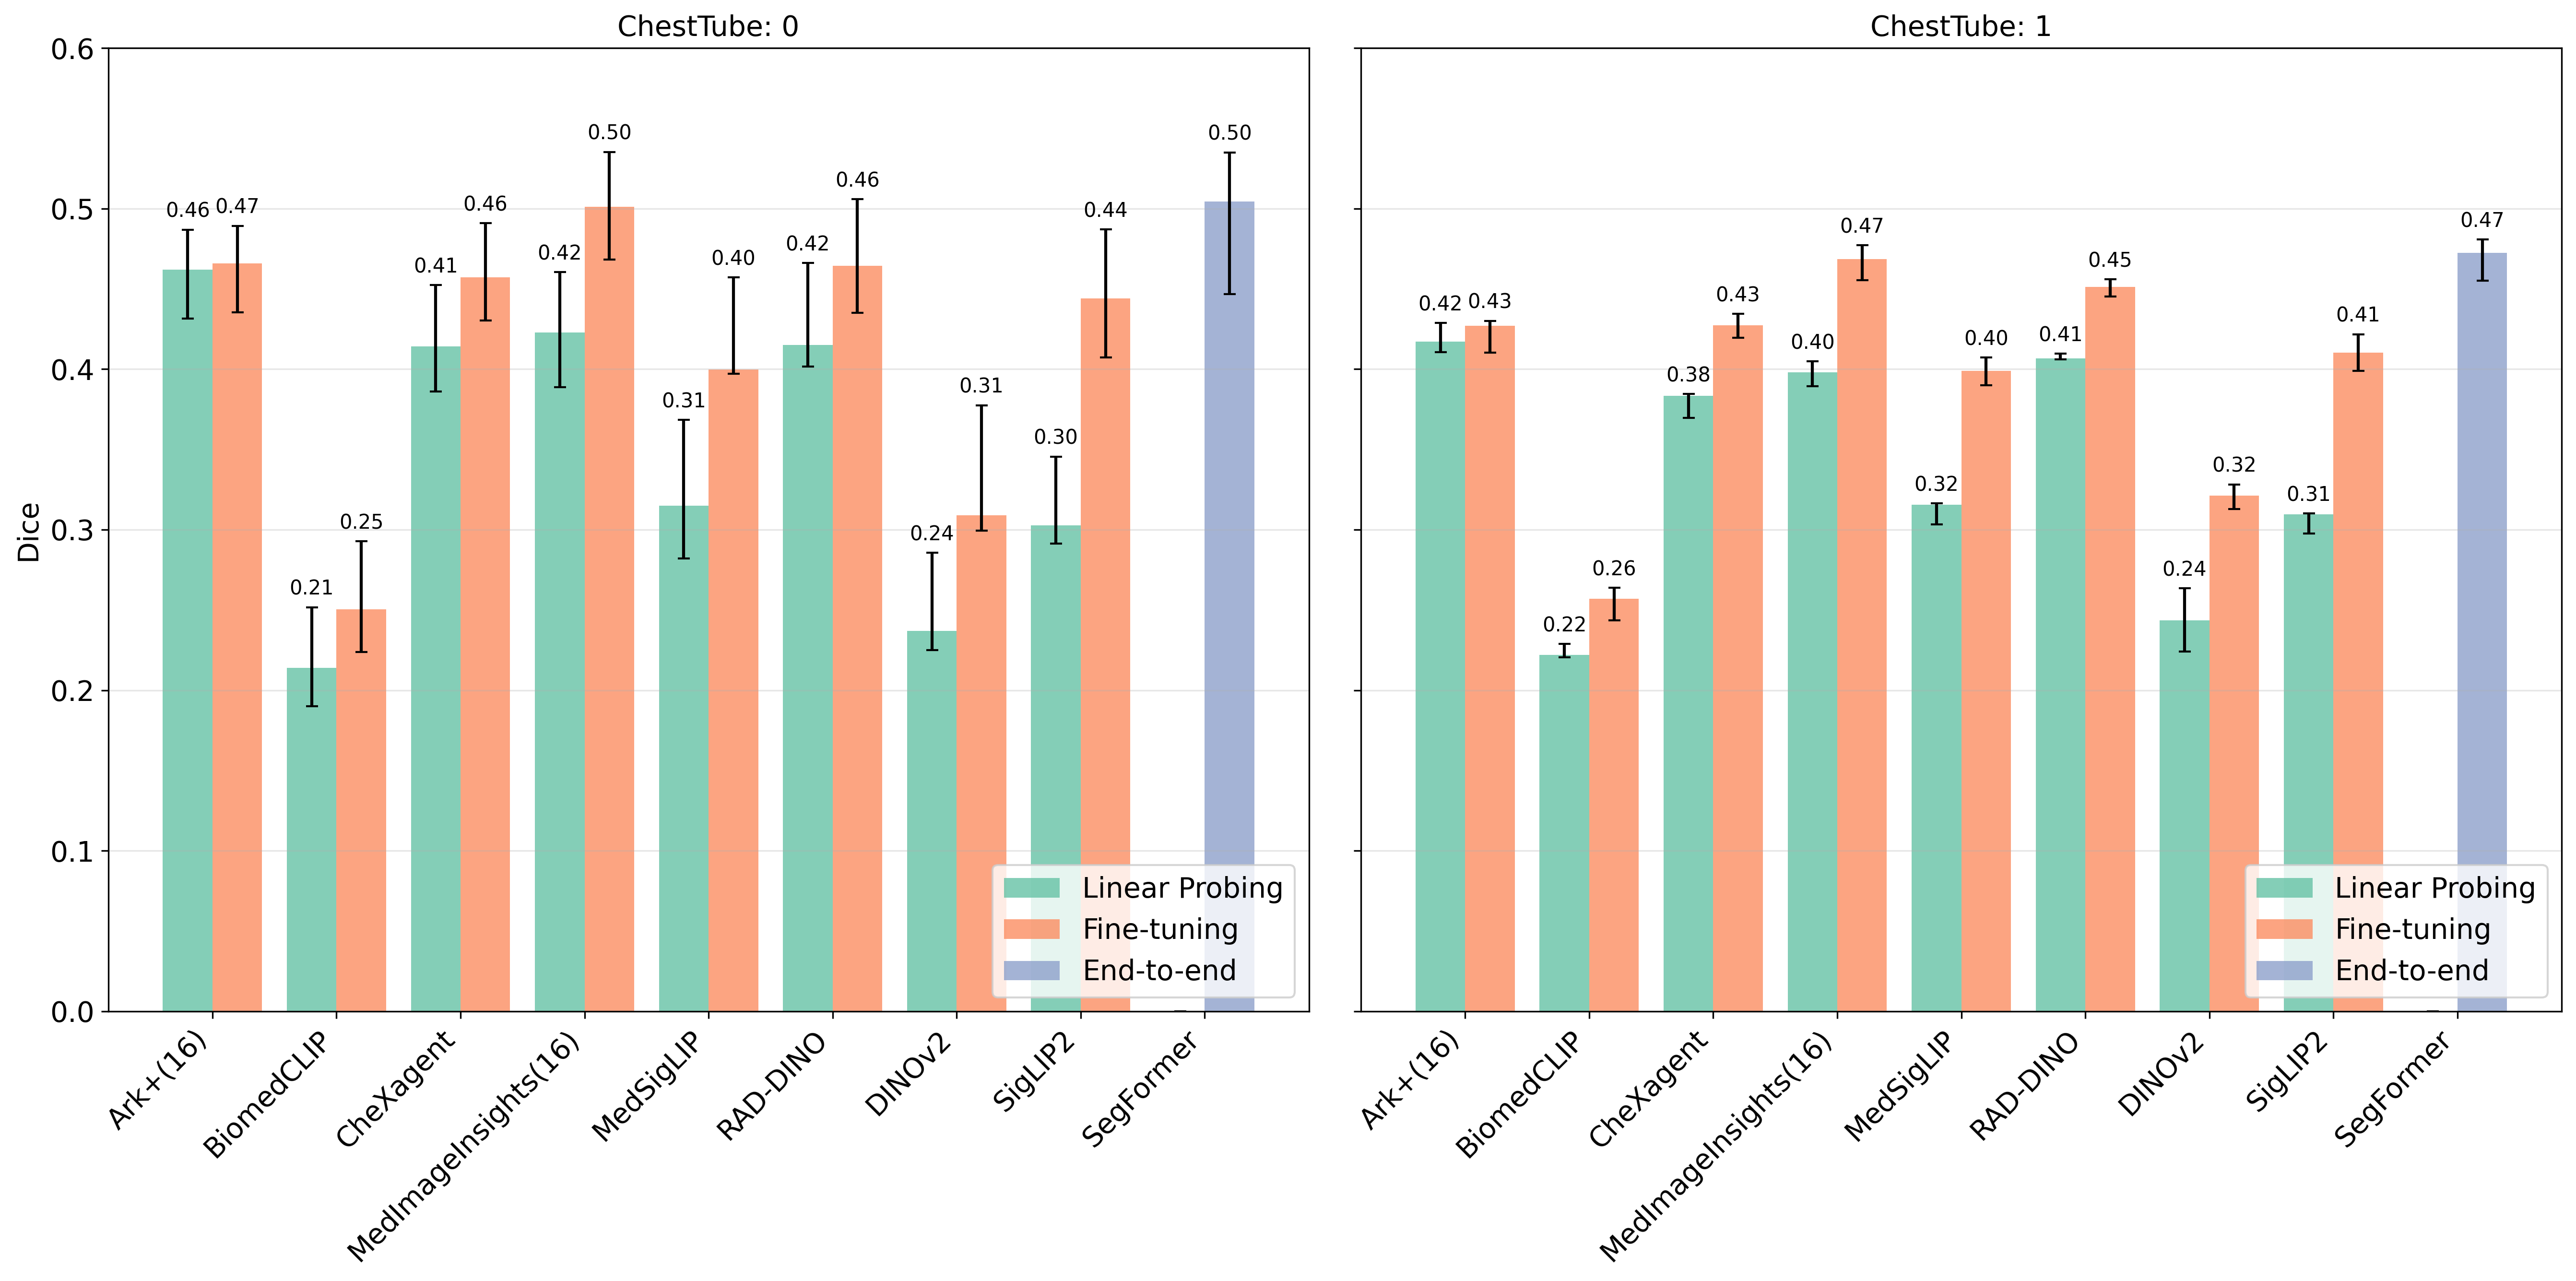

In [13]:
avg_dice_tube = calculate_subgroup_metric_median_stats(df, 'ChestTube', calculate_dice_mean, median_confidence_interval, metric_name='Dice')

fig, axes = plot_metric_by_quartile(avg_dice_tube, 'Dice', figsize=(18, 9), palette='Set2', quartile_col='ChestTube', y_lim=(0.0, 0.6), model_list=models, highlight_models='SegFormer', highlight_color=colors[2], highlight_label='End-to-end')
plt.show()

In [14]:
# avg_iou_vol = calculate_subgroup_metric_stats(df, 'Volume Quartile', calculate_iou_mean, calculate_CI_width, metric_name='IoU')

# fig, axes = plot_metric_by_freeze(avg_iou_vol, 'IoU', figsize=(18, 10), palette='viridis', quartile_col='Volume Quartile')
# plt.show()

/mnt/NAS3/homes/fli40/FM_evaluation/utils/stats.py:163: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  subgroup_metric = df_sub.groupby(['fold', 'model', 'freeze', groupby_column]).apply(metric_function)


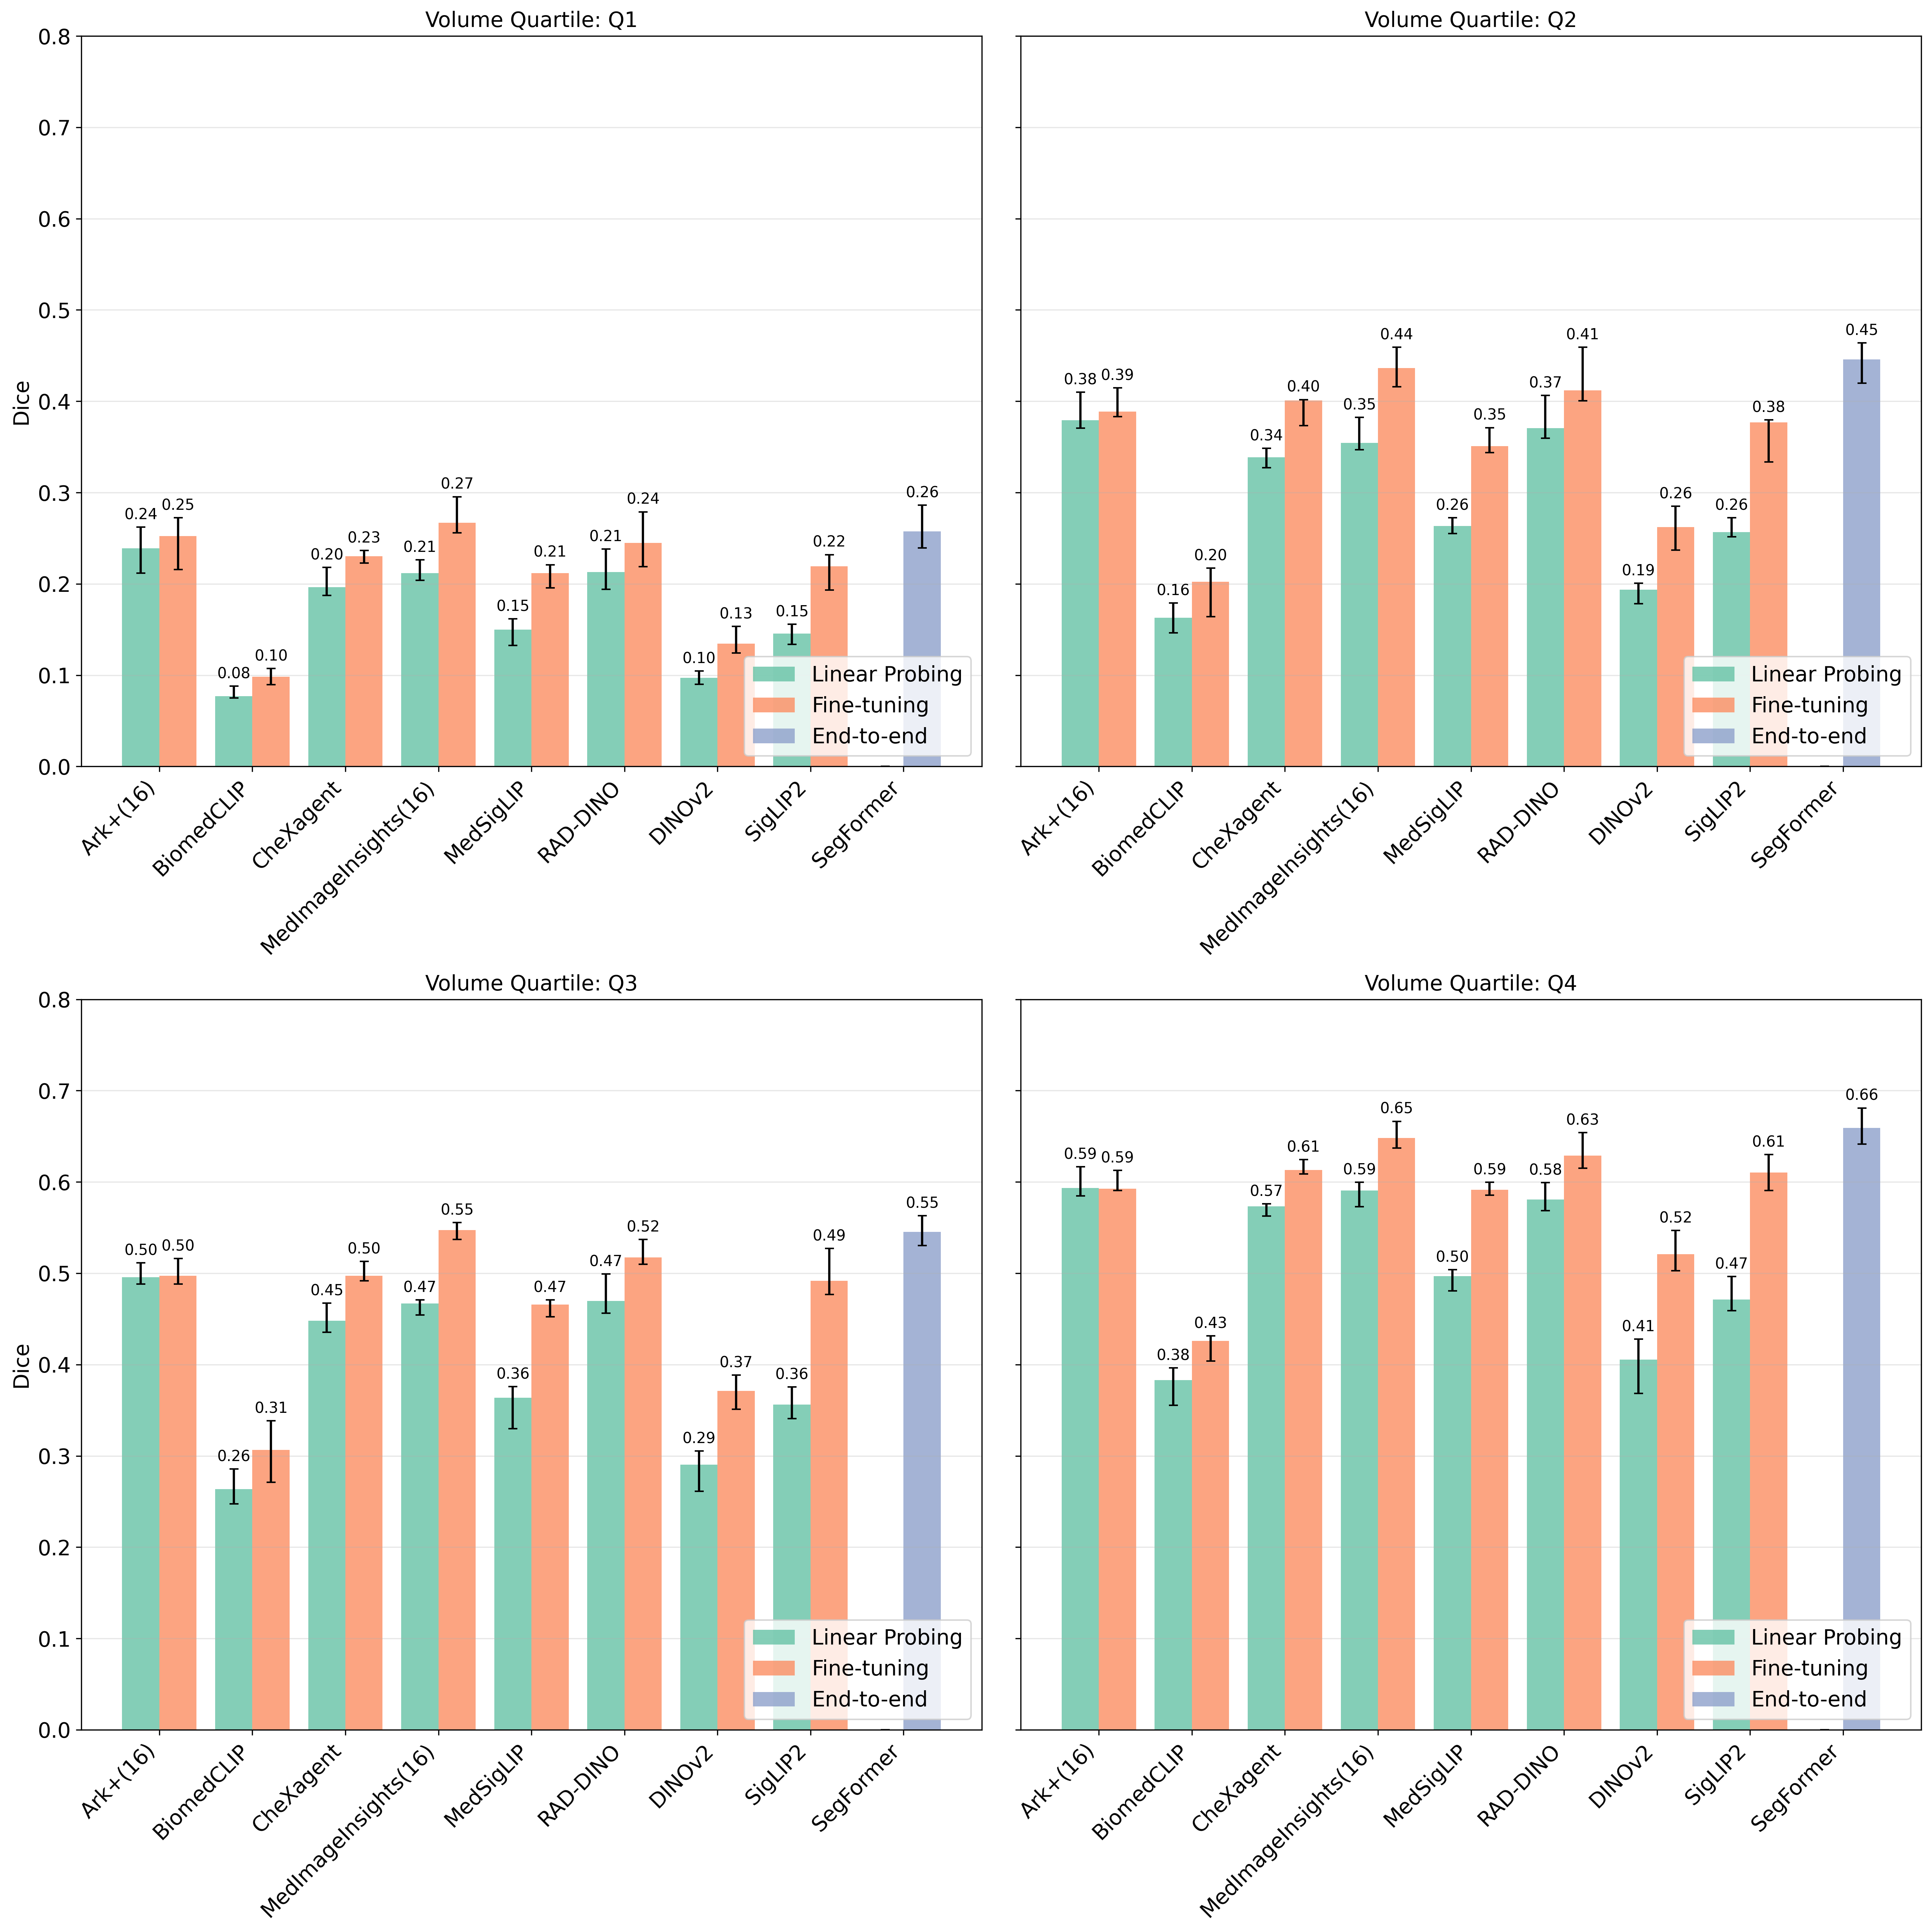

In [23]:
avg_dice_vol = calculate_subgroup_metric_median_stats(df, 'Volume Quartile', calculate_dice_mean, median_confidence_interval, metric_name='Dice')

fig, axes = plot_metric_by_quartile(avg_dice_vol, 'Dice', figsize=(18, 18), palette='Set2', quartile_col='Volume Quartile', y_lim=(0.0, 0.8), model_list=models, highlight_models='SegFormer', highlight_color=colors[2], highlight_label='End-to-end')
plt.show()

In [25]:
avg_dice_vol_tube = calculate_subgroup_metric_median_stats(df, 'Vol-Tube', calculate_dice_mean, median_confidence_interval, metric_name='Dice')

fig, axes = plot_metric_by_quartile(avg_dice_vol_tube, 'Dice', figsize=(18, 36), palette='Set2', quartile_col='Vol-Tube', y_lim=(0.0, 0.8), model_list=models, highlight_models='SegFormer', highlight_color=colors[2], highlight_label='End-to-end')
plt.show()

/mnt/NAS3/homes/fli40/FM_evaluation/utils/stats.py:163: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  subgroup_metric = df_sub.groupby(['fold', 'model', 'freeze', groupby_column]).apply(metric_function)


In [28]:
avg_dice_vol_tube_ = avg_dice_vol_tube[(avg_dice_vol_tube['Vol-Tube']=='Q1-0')|(avg_dice_vol_tube['Vol-Tube']=='Q1-1')]

/mnt/NAS3/homes/fli40/FM_evaluation/utils/stats.py:163: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  subgroup_metric = df_sub.groupby(['fold', 'model', 'freeze', groupby_column]).apply(metric_function)


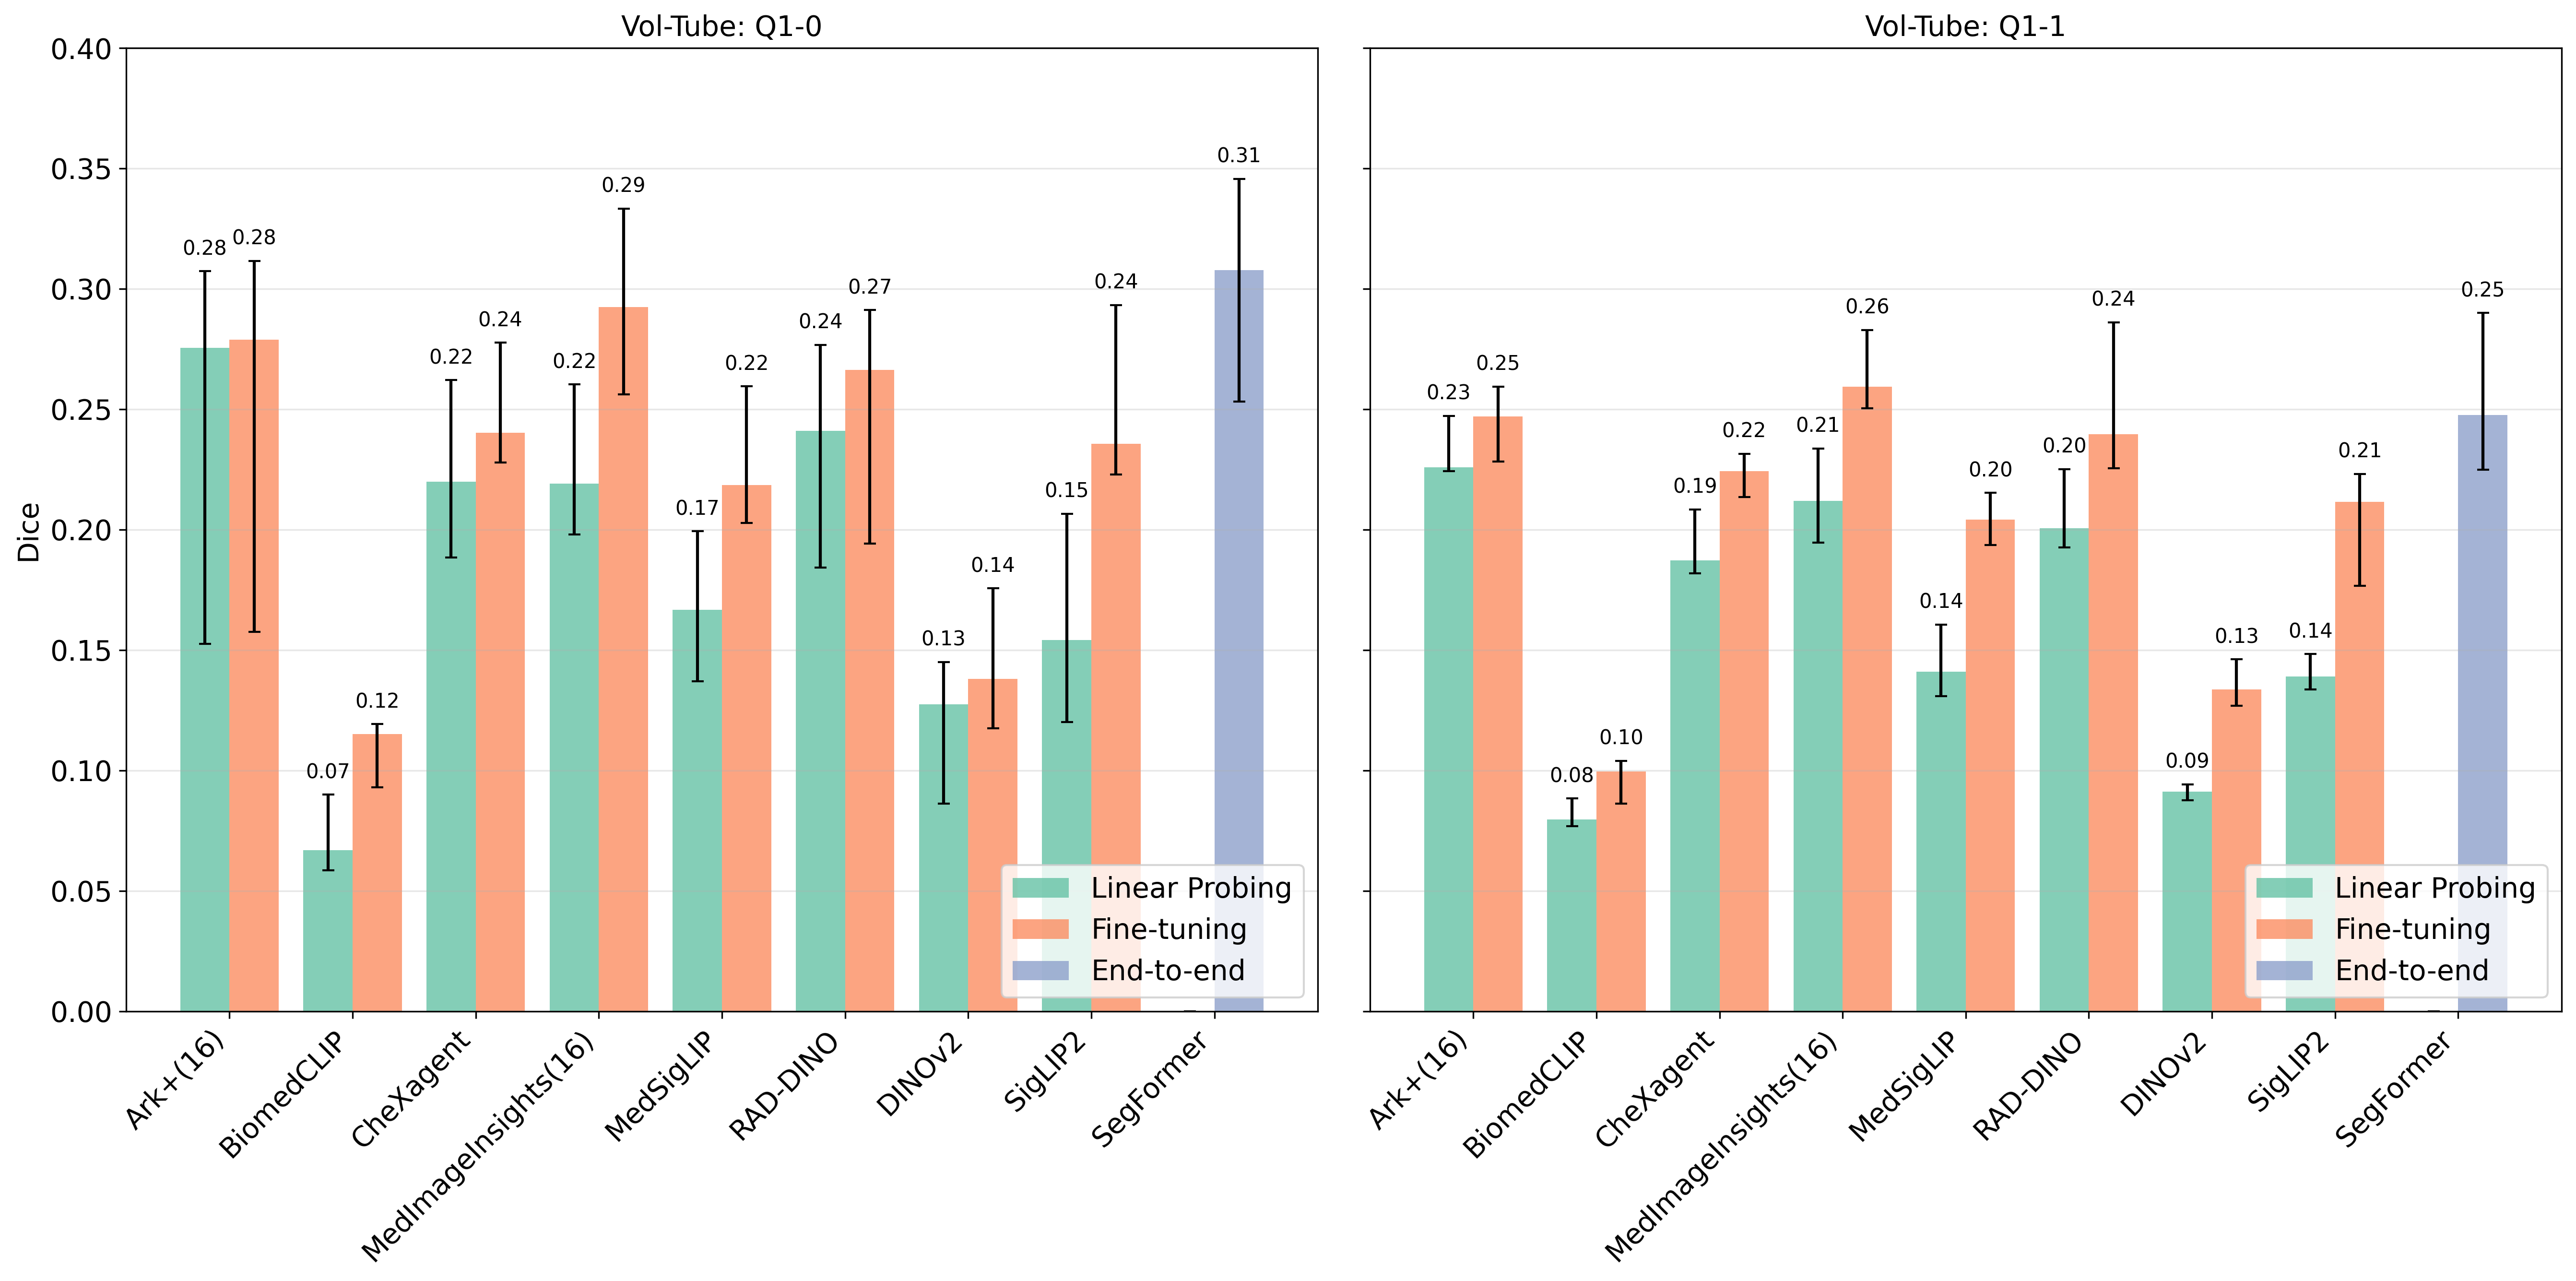

In [34]:
avg_dice_vol_tube = calculate_subgroup_metric_median_stats(df, 'Vol-Tube', calculate_dice_mean, median_confidence_interval, metric_name='Dice')

fig, axes = plot_metric_by_quartile(avg_dice_vol_tube_, 'Dice', figsize=(18, 9), palette='Set2', quartile_col='Vol-Tube', y_lim=(0.0, 0.4), model_list=models, highlight_models='SegFormer', highlight_color=colors[2], highlight_label='End-to-end')
plt.show()

In [17]:
avg_dice_vol_tube['Dice'] = avg_dice_vol_tube.apply(lambda x: f'{x['Dice']:.3f} ({x['ci_lower']:.3f}-{x['ci_upper']:.3f})', axis=1)
avg_dice_vol_tube_e2e = avg_dice_vol_tube[avg_dice_vol_tube.freeze==0].drop(columns=['ci_lower','ci_upper','freeze'])
avg_dice_vol_tube_fz = avg_dice_vol_tube[avg_dice_vol_tube.freeze==1].drop(columns=['ci_lower','ci_upper','freeze'])
avg_dice_vol_tube_ = avg_dice_vol_tube_fz.merge(avg_dice_vol_tube_e2e, on=['model','Vol-Tube'], suffixes=['_LinearProbing','_Fine-tuning'], how='right')
avg_dice_vol_tube_.to_csv('./stats/4_2_dice_comparison_seg_subgroup.csv', index=False)
avg_dice_vol_tube_

model Vol-Tube   Dice_LinearProbing     Dice_Fine-tuning
0   Ark+(16)     Q1-0  0.276 (0.153-0.307)  0.279 (0.158-0.312)
1   Ark+(16)     Q1-1  0.226 (0.224-0.247)  0.247 (0.228-0.259)
2   Ark+(16)     Q2-0  0.427 (0.353-0.453)  0.432 (0.359-0.472)
3   Ark+(16)     Q2-1  0.380 (0.351-0.391)  0.385 (0.362-0.391)
4   Ark+(16)     Q3-0  0.496 (0.465-0.519)  0.483 (0.474-0.526)
..       ...      ...                  ...                  ...
83   SigLIP2     Q2-1  0.253 (0.238-0.265)  0.364 (0.325-0.379)
84   SigLIP2     Q3-0  0.336 (0.257-0.382)  0.469 (0.454-0.513)
85   SigLIP2     Q3-1  0.367 (0.343-0.385)  0.498 (0.480-0.532)
86   SigLIP2     Q4-0  0.466 (0.415-0.492)  0.639 (0.616-0.660)
87   SigLIP2     Q4-1  0.480 (0.457-0.500)  0.609 (0.577-0.611)

[88 rows x 4 columns]

In [18]:
avg_dice_vol_tube_[(avg_dice_vol_tube_['Vol-Tube']=='Q1-0')|(avg_dice_vol_tube_['Vol-Tube']=='Q1-1')].to_csv('./stats/4_2_Q1_seg.csv')